In [4]:
import re, time, warnings, os, sys, copy
from typing import Union, Dict
import gzip, pickle

import numpy as np
import pandas as pd
import gzip, pickle
import scipy, sklearn, mne

import auxiliary as aux
import data, rsa
sys.path.append('../spaces/')
import embeddings as emb
import pubplot as pub
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

pub.styles.set()

In [5]:
C_s = pub.colours.equidistant('Paired', k = 12)
C = pub.colours.equidistant('tab20c', k = 20)

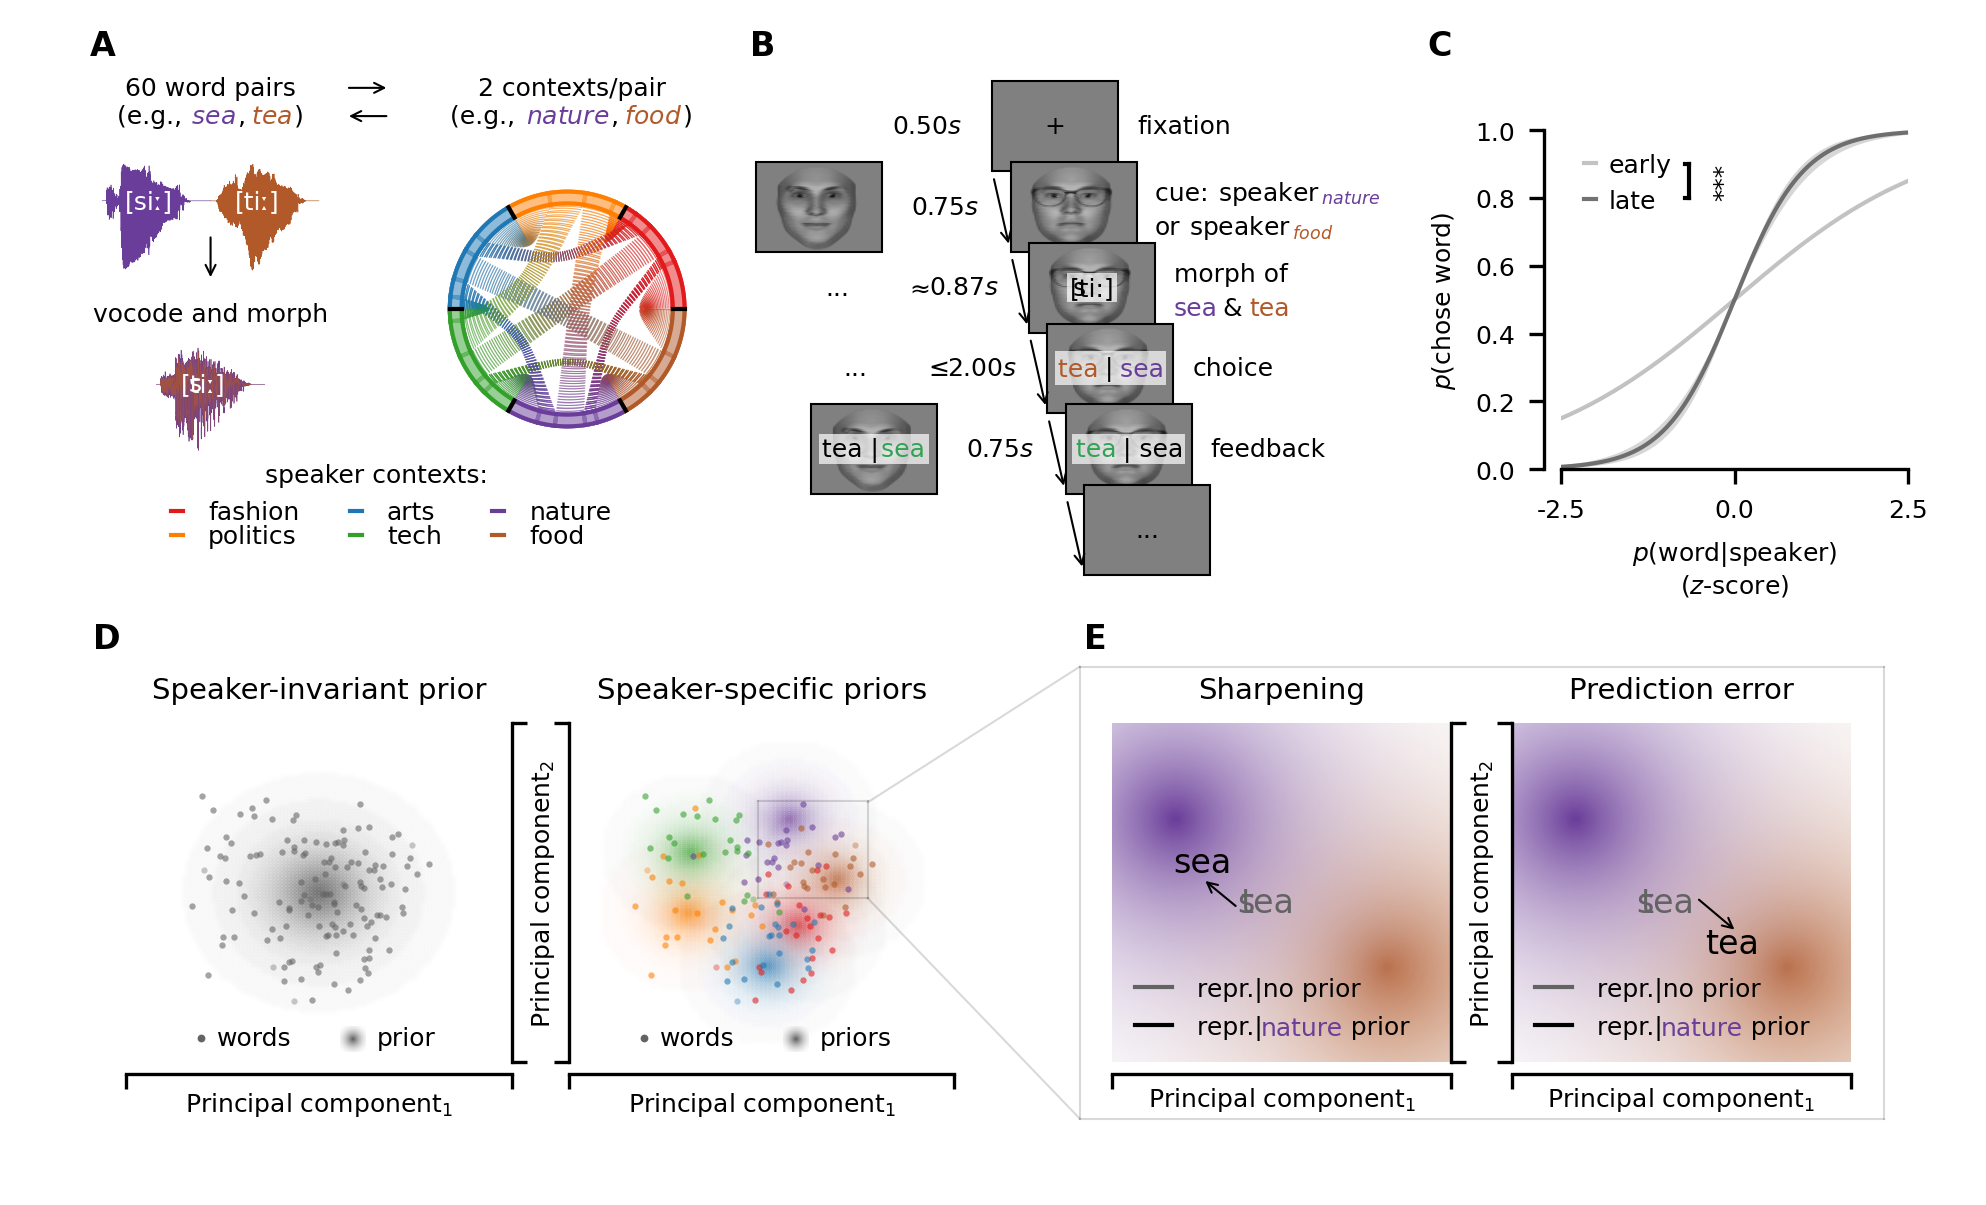

In [6]:
import data
from scipy.io import wavfile
import seaborn as sns

### setup figure
disable_edges = False

colours = dict(outdoor = C_s[9], essen = C_s[11], fashion = C_s[5], 
               politik = C_s[7], unterhaltung = C_s[1], technik = C_s[3])
labels = dict(outdoor = 'nature', essen = 'food', fashion = 'fashion',
              politik = 'politics', unterhaltung = 'arts', technik = 'tech')
stimulus_color = 'white'
order = np.array(['outdoor', 'essen', 'fashion', 'politik', 'unterhaltung', 'technik'])
CI = 1.96

sub = data.Subjects['0002'] # dont change
sid, pid = sub.sid, sub.pid

fig, ax = pub.figure(figsize = (6.6, 4.0))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.axis('off')

# add required axes
ax_stimuli = ax.inset_axes([0, 0.5, 0.375, 0.5]); ax_stimuli.axis('off')

'''
stimulus explainer
'''

ax_stimuli.set_xlim([0, 0.5])
ax_stimuli.set_ylim([0, 1])

ax_stimuli.annotate(r'60 word pairs' + '\n' + r'(e.g.,       ,      )', xy = (0.125, 0.9), xytext = (0.125, 0.9), ha = 'center', va = 'center')
ax_stimuli.annotate(r' $\it{sea}$ ', xy = (0.125, 0.875), xytext = (0.125, 0.875), color = colours['outdoor'], va = 'center', ha = 'center')
ax_stimuli.annotate(r'               $\it{tea}$ ', xy = (0.125, 0.875), xytext = (0.1265, 0.875), color = colours['essen'], va = 'center', ha = 'center')

fs, y = wavfile.read('./data/raw/audio/clear/See-Tee_D1.wav')
y0 = np.array(y) / np.array(y).max() * 0.065
y0 = y0[y0 != 0]
x = np.linspace(0.05, 0.125, y0.shape[0])
ax_stimuli.plot(x, 0.725+y0, color = colours['outdoor'], linewidth = .15)
ax_stimuli.annotate(r'[siː]', color = stimulus_color, xy = (0.0825, 0.725), xytext = (0.0825, 0.725), ha = 'center', va = 'center')
fs, y = wavfile.read('./data/raw/audio/clear/See-Tee_T1.wav')
y1 = np.array(y) / np.array(y).max() * 0.065
y1 = y1[y1 != 0]
ymin = min(y0.shape[0], y1.shape[0])
y0, y1 = y0[0:ymin], y1[0:ymin]
x = np.linspace(0.125, 0.2, y1.shape[0])
ax_stimuli.plot(x, 0.725+y1, color = colours['essen'], linewidth = .15)
ax_stimuli.annotate(r'[tiː]', color = stimulus_color, xy = (0.1575, 0.725), xytext = (0.1575, 0.725), ha = 'center', va = 'center')

ax_stimuli.annotate('', xy = (0.125, 0.575), xytext = (0.125, 0.675), arrowprops = dict(arrowstyle = '->', linewidth = 0.5))
ax_stimuli.annotate('vocode and morph', xy = (0.125, 0.525), xytext = (0.125, 0.525), ha = 'center', va = 'center')

x = np.linspace(0.0875, 0.1625, y1.shape[0])
y2 = (y0[0:y1.shape[0]]+y1)*0.6
ax_stimuli.plot(x, 0.4+y2, color = colours['outdoor'], linewidth = .15)
y2_c1 = y2[0::4]
y2_c1 = np.insert(y2_c1, np.arange(len(y2_c1))+1, y2[1::4])
x2_c1 = x[0::4]
x2_c1 = np.insert(x2_c1, np.arange(len(x2_c1))+1, x[1::4])
ax_stimuli.plot(x2_c1, 0.4+y2_c1, color = colours['essen'], linewidth = .05, alpha = 0.75)
ax_stimuli.annotate(r'[tiː]', color = stimulus_color, xy = (0.12, 0.4), xytext = (0.12, 0.4), ha = 'center', va = 'center')
ax_stimuli.annotate(r' s   ', color = stimulus_color, xy = (0.12, 0.4), xytext = (0.12, 0.4), ha = 'center', va = 'center')

ax_stimuli.annotate(r'2 contexts/pair' + '\n' + r'(e.g.,            ,        )', xy = (0.375, 0.9), xytext = (0.375, 0.9), ha = 'center', va = 'center')
ax_stimuli.annotate('\n' + r'$\it{nature}$', xy = (0.375, 0.9), xytext = (0.3725, 0.9), ha = 'center', va = 'center', color = colours['outdoor'])
ax_stimuli.annotate('\n' + r'                      $\it{food}$', xy = (0.375, 0.9), xytext = (0.371, 0.9), ha = 'center', va = 'center', color = colours['essen'])
ax_stimuli.annotate('', xy = (0.2525, 0.925), xytext = (0.215, 0.925), arrowprops = dict(arrowstyle = '->', linewidth = 0.5))
ax_stimuli.annotate('', xy = (0.215, 0.875), xytext = (0.2525, 0.875), arrowprops = dict(arrowstyle = '->', linewidth = 0.5))

'''
chord graph
'''

ax_chord = ax_stimuli.inset_axes([0.5, 0.25, 0.65, 0.65]); ax_chord.axis('equal'); ax_chord.axis('off')

nodes = dict(fashion = dict(N = 20, colour = colours['fashion']),
             politics = dict(N = 20, colour = colours['politik']),
             arts = dict(N = 20, colour = colours['unterhaltung']),
             tech = dict(N = 20, colour = colours['technik']),
             nature = dict(N = 20, colour = colours['outdoor']),
             food = dict(N = 20, colour = colours['essen']))

edges = dict(e0 = dict(f = 'fashion', t = 'food', w = 8),
             e1 = dict(f = 'fashion', t = 'nature', w = 2),
             e2 = dict(f = 'fashion', t = 'politics', w = 2),
             e3 = dict(f = 'fashion', t = 'arts', w = 3),
             e4 = dict(f = 'fashion', t = 'tech', w = 5),
             e5 = dict(f = 'food', t = 'nature', w = 5),
             e6 = dict(f = 'food', t = 'tech', w = 2),
             e7 = dict(f = 'food', t = 'arts', w = 5),
             e8 = dict(f = 'nature', t = 'politics', w = 5),
             e9 = dict(f = 'nature', t = 'tech', w = 5),
             e10 = dict(f = 'nature', t = 'arts', w = 3),
             e11 = dict(f = 'politics', t = 'tech', w = 6),
             e12 = dict(f = 'politics', t = 'arts', w = 7),
             e13 = dict(f = 'tech', t = 'arts', w = 2))

ax_chord.set_xlim([-2, 2])
ax_chord.set_ylim([-2, 2])
pub.graphs.chord(nodes, edges, xy = (-0.5, -0.2), edge = dict(linewidth = 0.25), sin_scale = 0.25, ax = ax_chord, disable_edges = disable_edges)
l1 = pub.cosmetics.legend(ax = ax_chord, handlelength = 0.5, borderpad = 0, labelspacing = 0, loc = 'lower center', ncols = 3, bbox_to_anchor = (0.0, -0.25))
for lh in l1.legend_handles: lh.set_alpha(1.0)
ax_stimuli.annotate('speaker contexts:', xy = (0.24, 0.24), xytext = (0.24, 0.24), ha = 'center', va = 'center', annotation_clip = False)

'''
design (learning)
'''

ax_design = ax.inset_axes([0.445, 0.325, 0.3, 0.675]); ax_design.axis('off')

# add design plot
pub.graphs.procedure([dict(T = 'text', stimulus = '+', delay = '', duration = 'fixation'),
                      dict(T = 'image', stimulus = './data/raw/misc/faces/face12_glasses3.png', delay = '', duration = r'cue: ' + '\n' + r''),
                      dict(T = 'image-text', stimulus = ('./data/raw/misc/faces/face12_glasses3.png', '[ti:]'), delay = '', duration = r'morph of ' + '\n' + r'', style = dict(bbox = dict(fc = 'white', ec = 'None', boxstyle = 'square,pad=0.1', alpha = .7))),
                      dict(T = 'image-text', stimulus = ('./data/raw/misc/faces/face12_glasses3.png', r'      $|$       '), delay = '', duration = r'choice', style = dict(bbox = dict(fc = 'white', ec = 'None', boxstyle = 'square,pad=0.1', alpha = .7))),
                      dict(T = 'image-text', stimulus = ('./data/raw/misc/faces/face12_glasses3.png', r'      | sea'), delay = r'', duration = r'feedback', style = dict(bbox = dict(fc = 'white', ec = 'None', boxstyle = 'square,pad=0.1', alpha = .7))),
                      dict(T = 'text', stimulus = '...')], spacing_x = 0.35, offset_x = 1.5, offset_y = 2, ax = ax_design)
pub.graphs.procedure([dict(T = 'text-only', stimulus = '        sea', style = dict(color = colours['outdoor']))], 
                      spacing_x = 0.35, offset_x = 2.545, offset_y = -3.415, show_delay = False, ax = ax_design)
pub.graphs.procedure([dict(T = 'text-only', stimulus = 'tea        ', style = dict(color = colours['essen']))], 
                      spacing_x = 0.35, offset_x = 2.545, offset_y = -3.415, show_delay = False, ax = ax_design)
pub.graphs.procedure([dict(T = 'image', stimulus = './data/raw/misc/faces/face7_piercing2.png', style = dict(clip_on = False)),
                      dict(T = 'text-only', stimulus = '...'),
                      dict(T = 'text-only', stimulus = '...'),
                      dict(T = 'image-text', stimulus = ('./data/raw/misc/faces/face7_piercing2.png', r'tea |      '), style = dict(bbox = dict(fc = 'white', ec = 'None', boxstyle = 'square,pad=0.1', alpha = .7)))], 
                     spacing_x = 0.35, offset_x = -3.0, offset_y = 0.2, show_delay = False, ax = ax_design)
pub.graphs.procedure([dict(T = 'text-only', stimulus = 's   ')], 
                      spacing_x = 0.35, offset_x = 2.2, offset_y = -1.6, show_delay = False, ax = ax_design)
pub.graphs.procedure([dict(T = 'text-only', stimulus = '        sea', style = dict(color = C[8]))], 
                      spacing_x = 0.35, offset_x = -2.0, offset_y = -5.2, show_delay = False, ax = ax_design)
pub.graphs.procedure([dict(T = 'text-only', stimulus = 'tea        ', style = dict(color = C[8]))], 
                      spacing_x = 0.35, offset_x = 2.9, offset_y = -5.2, show_delay = False, ax = ax_design)
ax_design.set_xlim([-0.5, 10.5])
ax_design.set_ylim([-14, 3])

ax_design.annotate(r'speaker$_{      }$', xy = (5.8, -0.45), xytext = (5.8, -0.45), annotation_clip = False)
ax_design.annotate(r'             $_{nature}$', xy = (5.8, -0.45), xytext = (5.8, -0.45), color = colours['outdoor'], annotation_clip = False)
ax_design.annotate(r'or', xy = (4.6, -1.2), xytext = (4.6, -1.2), annotation_clip = False)
ax_design.annotate(r'speaker$_{    }$', xy = (5.25, -1.2), xytext = (5.25, -1.2), annotation_clip = False)
ax_design.annotate(r'             $_{food}$', xy = (5.25, -1.2), xytext = (5.25, -1.2), color = colours['essen'], annotation_clip = False)

ax_design.annotate(r'sea', xy = (7.35, -2.25), xytext = (4.95, -3), color = colours['outdoor'], annotation_clip = False)
ax_design.annotate(r' &', xy = (8.15, -2.25), xytext = (5.75, -3), annotation_clip = False)
ax_design.annotate(r'tea', xy = (4.95, -3), xytext = (6.4, -3), color = colours['essen'], annotation_clip = False)

ax_design.annotate(r'$0.50s$', xy = (8.15, -1.2), xytext = (-0.4, 1.05), annotation_clip = False)
ax_design.annotate(r'$0.75s$', xy = (8.15, -1.2), xytext = (-0.05, -0.75), annotation_clip = False)
ax_design.annotate(r'$0.87s$', xy = (8.15, -1.2), xytext = (0.3, -2.55), annotation_clip = False)
ax_design.annotate(r'$\approx$', xy = (8.15, -1.2), xytext = (-0.15, -2.55), annotation_clip = False)
ax_design.annotate(r'$2.00s$', xy = (8.15, -1.2), xytext = (0.65, -4.35), annotation_clip = False)
ax_design.annotate(r'$\leq$', xy = (8.15, -1.2), xytext = (0.2, -4.35), annotation_clip = False)
ax_design.annotate(r'$0.75s$', xy = (8.15, -1.2), xytext = (1.00, -6.15), annotation_clip = False)

'''
learning task behaviour
'''

data = pd.read_csv(f'./data/processed/beh/mt1/fitted.csv')
model = pub.model.read(f'./data/processed/beh/mt1/summary.csv', properties = ['ß', 'se', 'z', 'p'])

z_no = np.linspace(np.min(data.z_no.tolist()), np.max(data.z_no.tolist()), int(1e3))
kappa = np.linspace(np.min(data.kappa.tolist()), np.max(data.kappa.tolist()), int(1e3))
#z_fit = np.linspace(np.min(data.z_fit.tolist()), np.max(data.z_fit.tolist()), int(1e3))
z_fit = np.linspace(-2.5, 2.5, int(1e3))

def sig(p):
    return '***' if p <= 1e-3 else '**' if p <= 1e-2 else '*' if p <= 0.05 else ' n.s.'

ax_learning = ax.inset_axes([0.795, 0.625, 0.18, 0.3])

pub.ribbon.from_coef(z_fit, [#(model.z_no.ß, model.z_no.se, z_no.min() * np.ones_like(z_fit)),
                             (model.z_fit.ß, model.z_fit.se, z_fit),
                             (model.z_no_by_z_fit.ß, model.z_no_by_z_fit.se, z_no.min() * z_fit)], 
                     CI = CI, link = pub.link.logit, 
                     ribbon = dict(color = C[18]), mean = dict(color = C[18], label = r'early'), ax = ax_learning)
pub.ribbon.from_coef(z_fit, [#(model.z_no.ß, model.z_no.se, z_no.max() * np.ones_like(z_fit)),
                             (model.z_fit.ß, model.z_fit.se, z_fit),
                             (model.z_no_by_z_fit.ß, model.z_no_by_z_fit.se, z_no.max() * z_fit)], 
                     CI = CI, link = pub.link.logit, 
                     ribbon = dict(color = C[16]), mean = dict(color = C[16], label = r'late'), ax = ax_learning)
#pub.dist.violins(np.array([data.z_fit.tolist()]), colours = [C[16]], mean = False, CI = False, scatter = False, density_max = 0.25, density_theta = 0, ax = ax_learning)

ax_learning.set_ylim([0, 1])
ax_learning.set_ylabel(r'$p($chose word$)$')
ax_learning.set_xlim([-2.5, 2.5])
ax_learning.set_xticks(np.arange(-2.5, 2.6, 2.5), labels = ['-2.5', '0.0', '2.5'])
ax_learning.set_xlabel(r'$p($word$|$speaker$)$' + '\n' r'($z$-score)')
#ax_learning.set_title(r'Behavioural responses', fontsize = 6)
pub.cosmetics.legend(ax = ax_learning, loc = 'upper left', handlelength = 0.5, handletextpad = 0.5)
ax_learning.spines['left'].set_position(('data', -2.75))

pub.significance.pair(fr'{sig(model.z_no_by_z_fit.p)}', coords_a = (-0.65, 0.9), coords_b = (-0.65, 0.8), ax = ax_learning,
                      pro_shift_x = -0.0125, pro_shift_y = 0, significance = dict(rotation = 90),
                      sig_shift_x = 0.1, sig_shift_y = 0, theta = 0)
sns.despine(ax = ax_learning)

'''
space plot
'''

import data

# load behaviour
df = pd.read_csv(f'./data/raw/beh/sub{sid}/{pid}.csv')
beh = df.loc[(df.type == data.defs.TRIAL_MT_MAIN) | (df.type == data.defs.TRIAL_MT_CONTROL) | (df.type == data.defs.TRIAL_MT_PRACTICE)].reset_index(drop = True)

# load embedding
G = emb.glove.load_embedding(f_in = './data/preprocessed/misc/glove/w2v_50D.txt') # mini version

# setup contexts & priors
contexts = np.array(['essen', 'fashion', 'outdoor', 'technik', 'politik', 'unterhaltung'])

# update priors
context = np.array(beh.context.tolist())[-1]
with gzip.open(f'./data/raw/rtfe/sub{sid}/{pid}_t263_{context}.pkl.gz', 'rb') as f:
    _, _, _, posterior, _, _ = pickle.load(f)
priors = posterior.T

with gzip.open(f'./data/raw/rtfe-unspecific/sub{sid}/{pid}_t263_essen.pkl.gz', 'rb') as f:
    _, _, _, posterior, _, _ = pickle.load(f)
priors_uns = posterior.T
    
# load all words
words = np.array(beh.options_0.tolist())
speakers = np.array(beh.context.tolist())
embeddings = np.array([G[word.lower()] for word in words])

# load projected priors
(X_w, X_u, X_p) = np.load(f'./figures/resources/fig1_priors.npy', allow_pickle = True)

ax_learned = ax.inset_axes([0.05, 0.1, 0.2, 0.3])
ax_unlearn = ax.inset_axes([0.28, 0.1, 0.2, 0.3])

N = 75
coffset = 3.0
TEMP = 3

for i, c in enumerate(order):
    indc = np.where(speakers == c)[0]
    cindx = np.where(contexts == c)[0][0]
    
    grid_x, grid_y = np.linspace(X_p[cindx,0] - coffset, X_p[cindx,0] + coffset, N), np.linspace(X_p[cindx,1] - coffset, X_p[cindx,1] + coffset, N)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    ref = np.array([grid_x.flatten(), grid_y.flatten()]).T
    
    prob = rsa.math.euclidean(ref, X_p[cindx,None,:] * np.ones_like(ref))
    prob = np.exp(TEMP * prob) / np.exp(TEMP * prob).sum()
    prob = 1 / prob
    prob = prob / prob.max()
    prob = prob * 0.25
    
    ax_unlearn.scatter(ref[:,0], ref[:,1], marker = '.', s = 5, alpha = prob, color = colours[c])

TEMP = 2.0
coffset = 5.0
N = 150

grid_x, grid_y = np.linspace(X_p[:,0].mean() - coffset, X_p[:,0].mean() + coffset, N), np.linspace(X_p[:,1].mean() - coffset, X_p[:,1].mean() + coffset, N)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)
ref = np.array([grid_x.flatten(), grid_y.flatten()]).T

prob = rsa.math.euclidean(ref, X_p[:,:].mean(axis = 0, keepdims = True) * np.ones_like(ref))
prob = np.exp(TEMP * prob) / np.exp(TEMP * prob).sum()
prob = 1 / prob
prob = prob / prob.max()
prob = prob * 0.25

ax_learned.scatter(ref[:,0], ref[:,1], marker = '.', s = 5, alpha = prob, color = C[16])
    
for i, c in enumerate(order):
    indc = np.where(speakers == c)[0]
    ax_unlearn.scatter(X_w[indc,0], X_w[indc,1], color = colours[c], marker = '.', s = 1, alpha = 0.35, label = 'words' if i == 0 else None)
    ax_learned.scatter(X_w[indc,0], X_w[indc,1], color = C[16], marker = '.', s = 1, alpha = 0.35, label = 'words' if i == 0 else None)

for i, c in enumerate(order):
    j = np.where(contexts == c)[0]
    cindx = np.where(contexts == c)[0][0]
    ax_unlearn.scatter(X_p[cindx,0], X_p[cindx,1], color = colours[c], marker = 'o', s = 10, label = 'priors' if i == 0 else None, alpha = 0.0)
ax_learned.scatter(X_u[0,0], X_u[0,1], color = C[16], marker = 'o', s = 10, label = 'prior', alpha = 0.0)

for ax_i in [ax_learned, ax_unlearn]:
    ax_i.set_xlim([-3.5, 3.5])
    ax_i.set_xticks([])
    ax_i.set_xticklabels([])
    ax_i.set_ylim([-3.5, 3.5])
    ax_i.set_yticks([])
    ax_i.set_yticklabels([])

ax_learned.yaxis.set_label_position("right")
ax_learned.yaxis.tick_right()
ax_learned.set_title('Speaker-invariant prior', fontsize = 7)
ax_unlearn.set_title('Speaker-specific priors', fontsize = 7)

ax_learned.scatter([-2.15], [-3.0], marker = '.', s = 3, color = C[16])
ax_learned.annotate('words', xy = (0,0), xytext = (-1.85, -3.0), ha = 'left', va = 'center')

f_ax = ax_learned.inset_axes([0.55, 0.03, 0.075, 0.075]); f_ax.axis('off')
xs, ys = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
rad = np.sqrt((xs - 0.5) ** 2 + (ys - 0.5) ** 2)
zad = np.where(rad < 0.01, np.nan, np.clip(1 - rad, 0, np.inf))
cmap = LinearSegmentedColormap.from_list('', ['#FFFFFF00', C[16]])
cmap.set_bad(C[16])
f_ax.imshow(zad, cmap=cmap, extent=[0, 1, 0, 1], origin='lower', zorder = 3)
ax_learned.annotate('prior', xy = (0, 0), xytext = (1.05, -3.0), ha = 'left', va = 'center')

ax_learned.spines[['left', 'top']].set_visible(False)
ax_learned.spines[['right']].set_visible(True)
sns.despine(ax = ax_unlearn)

ax_unlearn.scatter([-2.15], [-3.0], marker = '.', s = 3, color = C[16])
ax_unlearn.annotate('words', xy = (0,0), xytext = (-1.85, -3.0), ha = 'left', va = 'center')

f_ax = ax_unlearn.inset_axes([0.55, 0.03, 0.075, 0.075]); f_ax.axis('off')
xs, ys = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
rad = np.sqrt((xs - 0.5) ** 2 + (ys - 0.5) ** 2)
zad = np.where(rad < 0.01, np.nan, np.clip(1 - rad, 0, np.inf))
cmap = LinearSegmentedColormap.from_list('', ['#FFFFFF00', C[16]])
cmap.set_bad(C[16])
f_ax.imshow(zad, cmap=cmap, extent=[0, 1, 0, 1], origin='lower', zorder = 3)
ax_unlearn.annotate('priors', xy = (0, 0), xytext = (1.05, -3.0), ha = 'left', va = 'center')

ax_unlearn.spines['bottom'].set_position(('data', -3.75))
ax_unlearn.set_xticks([-3.5, 3.5], labels = ['', ''])
ax_unlearn.set_yticks([-3.5, 3.5], labels = ['', ''])

ax_learned.spines['bottom'].set_position(('data', -3.75))
ax_learned.set_xticks([-3.5, 3.5], labels = ['', ''])
ax_learned.set_yticks([-3.5, 3.5], labels = ['', ''])
ax_learned.annotate(r'Principal component$_2$', annotation_clip = False, xy = (0, 0), xytext = (4.0725, 0.0), ha = 'center', va = 'center', fontsize = 6, rotation = 90)
ax_learned.annotate(r'Principal component$_1$', annotation_clip = False, xy = (0, 0), xytext = (0.0, -4.375), ha = 'center', va = 'center', fontsize = 6, rotation = 0)
ax_unlearn.annotate(r'Principal component$_1$', annotation_clip = False, xy = (0, 0), xytext = (0.0, -4.375), ha = 'center', va = 'center', fontsize = 6, rotation = 0)

'''
PE/SH plot
'''

ax_pesh_nat = ax.inset_axes([0.55, 0.1, 0.2, 0.3])
ax_pesh_fod = ax.inset_axes([0.7575, 0.1, 0.2, 0.3])

TEMP = 1
offset = 1.0
coffset = 5
N = 200

cindx_nat = np.where(contexts == 'outdoor')[0][0]
cindx_fod = np.where(contexts == 'essen')[0][0]

p_nat = X_p[cindx_nat,None,None,:]
p_fod = X_p[cindx_fod,None,None,:]
p_mid = (p_nat + p_fod) / 2

zoom_xmin, zoom_xmax = p_mid.squeeze()[0] - offset, p_mid.squeeze()[0] + offset
zoom_ymin, zoom_ymax = p_mid.squeeze()[1] - offset, p_mid.squeeze()[1] + offset

grid_x, grid_y = np.linspace(zoom_xmin, zoom_xmax, N), np.linspace(zoom_ymin, zoom_ymax, N)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)
grid = np.array([grid_x, grid_y]).T

for i, (c, cs) in enumerate(zip(['outdoor', 'essen'], ['essen', 'outdoor'])):
    cindx = np.where(contexts == c)[0][0]
    p_indx = X_p[cindx,None,None,:]

    cmap = LinearSegmentedColormap.from_list('', ['#FFFFFF00', colours[cs]])
    prob = rsa.math.euclidean(grid, p_indx * np.ones_like(grid))
    prob = prob / prob.max()
    prob = np.exp(TEMP * prob) / np.exp(TEMP * prob).sum()
    prob = 1 / prob
    prob /= prob.max()
    
    ax_pesh_nat.imshow(prob, cmap = cmap, zorder = 1, alpha = 1.0, origin = 'lower')
    ax_pesh_fod.imshow(prob, cmap = cmap, zorder = 1, alpha = 1.0, origin = 'lower')

indx_s = np.where(words == 'See')[0][0]
indx_t = np.where(words == 'Tee')[0][0]

pos_s = rsa.math.euclidean(X_w[None,None,indx_s,:] * np.ones_like(grid), grid)
pos_s = np.unravel_index(pos_s.argmin(), grid.shape[0:2])
pos_t = rsa.math.euclidean((X_w[None,None,indx_t,:] + np.array([-0.1, -0.2])) * np.ones_like(grid), grid)
pos_t = np.unravel_index(pos_t.argmin(), grid.shape[0:2])
pos_m = tuple((np.array(pos_t) + np.array(pos_s)) / 2)

ax_pesh_nat.plot([0, 0], [0, 0], color = C[16], label = r'repr.|no prior')
ax_pesh_nat.plot([0, 0], [0, 0], color = 'black', label = r'repr.|           prior')
ax_pesh_nat.annotate('tea', xy = pos_m, xytext = pos_m, ha = 'center', va = 'center', fontsize = 8, color = C[16])
ax_pesh_nat.annotate('s    ', xy = pos_m, xytext = pos_m, ha = 'center', va = 'center', fontsize = 8, color = C[16])
ax_pesh_nat.annotate('sea', xy = pos_s, xytext = pos_s, ha = 'center', va = 'center', fontsize = 8)
ax_pesh_nat.annotate('', xy = tuple(np.array(pos_s) - np.array([2, 8])), xytext = tuple(np.array(pos_m) - np.array([15, 5])), arrowprops = dict(arrowstyle = '->', linewidth = 0.5))
pub.cosmetics.legend(ax = ax_pesh_nat, loc = 'lower left', fontsize = 6)

ax_pesh_fod.plot([0, 0], [0, 0], color = C[16], label = 'repr.|no prior')
ax_pesh_fod.plot([0, 0], [0, 0], color = 'black', label = r'repr.|           prior')
ax_pesh_fod.annotate('tea', xy = pos_m, xytext = pos_m, ha = 'center', va = 'center', fontsize = 8, color = C[16])
ax_pesh_fod.annotate('s    ', xy = pos_m, xytext = pos_m, ha = 'center', va = 'center', fontsize = 8, color = C[16])
ax_pesh_fod.annotate('tea', xy = pos_t, xytext = pos_t, ha = 'center', va = 'center', fontsize = 8)
ax_pesh_fod.annotate('', xy = tuple(np.array(pos_t) - np.array([-5, -5])), xytext = tuple(np.array(pos_m) - np.array([-15, -5])), arrowprops = dict(arrowstyle = '->', linewidth = 0.5))
pub.cosmetics.legend(ax = ax_pesh_fod, loc = 'lower left', fontsize = 6)

ax_pesh_fod.annotate('nature', xy = (20, 5), xytext = (112, 20), ha = 'center', va = 'center', color = colours['outdoor'])
ax_pesh_nat.annotate('nature', xy = (20, 5), xytext = (112, 20), ha = 'center', va = 'center', color = colours['outdoor'])

ax_pesh_nat.set_xticks([])
ax_pesh_nat.set_yticks([])
ax_pesh_fod.set_xticks([])
ax_pesh_fod.set_yticks([])
ax_pesh_nat.set_title(r'Sharpening', fontsize = 7)
ax_pesh_fod.set_title(r'Prediction error', fontsize = 7)

ax_pesh_nat.yaxis.set_label_position("right")
ax_pesh_nat.yaxis.tick_right()
#ax_pesh_nat.set_xlabel(r'Principal component$_1$', fontsize = 6)
#ax_pesh_nat.set_ylabel(r'Principal component$_2$', fontsize = 6)
#ax_pesh_fod.set_xlabel(r'Principal component$_1$', fontsize = 6)
sns.despine(ax = ax_pesh_nat)
ax_pesh_nat.spines[['left', 'top']].set_visible(False)
ax_pesh_nat.spines[['right']].set_visible(True)
sns.despine(ax = ax_pesh_fod)

ax_pesh_nat.spines['bottom'].set_position(('data', -7))
ax_pesh_nat.set_xlim([0, 200])
ax_pesh_nat.set_xticks([0, 200], labels = ['', ''])
ax_pesh_nat.spines['right'].set_position(('data', 200))
ax_pesh_nat.set_ylim([0, 200])
ax_pesh_nat.set_yticks([0, 200], labels = ['', ''])
ax_pesh_nat.annotate(r'Principal component$_1$', annotation_clip = False, xy = (0, 0), xytext = (100, -22), ha = 'center', va = 'center', fontsize = 6, rotation = 0)
ax_pesh_nat.annotate(r'Principal component$_2$', annotation_clip = False, xy = (0, 0), xytext = (218, 100), ha = 'center', va = 'center', fontsize = 6, rotation = 90)
ax_pesh_fod.annotate(r'Principal component$_1$', annotation_clip = False, xy = (0, 0), xytext = (100, -22), ha = 'center', va = 'center', fontsize = 6, rotation = 0)

ax_pesh_fod.spines['bottom'].set_position(('data', -7))
ax_pesh_fod.set_xlim([0, 200])
ax_pesh_fod.set_xticks([0, 200], labels = ['', ''])
ax_pesh_fod.spines['right'].set_position(('data', 200))
ax_pesh_fod.set_ylim([0, 200])
ax_pesh_fod.set_yticks([0, 200], labels = ['', ''])

# create call-out
ax_unlearn.plot([zoom_xmin, zoom_xmin], [zoom_ymin, zoom_ymax], linewidth = 0.5, color = 'black', alpha = 0.15)
ax_unlearn.plot([zoom_xmax, zoom_xmax], [zoom_ymin, zoom_ymax], linewidth = 0.5, color = 'black', alpha = 0.15)
ax_unlearn.plot([zoom_xmin, zoom_xmax], [zoom_ymin, zoom_ymin], linewidth = 0.5, color = 'black', alpha = 0.15)
ax_unlearn.plot([zoom_xmin, zoom_xmax], [zoom_ymax, zoom_ymax], linewidth = 0.5, color = 'black', alpha = 0.15)

co_xmaxa, co_ymina, co_ymaxa = 0.435, 0.245, 0.33
co_xminb, co_xmaxb = 0.545, 0.9625
co_yminb, co_ymaxb = 0.05, 0.45

ax.plot([co_xmaxa, co_xminb], [co_ymina, co_yminb], color = 'black', linewidth = 0.5, alpha = 0.15, zorder=999)
ax.plot([co_xmaxa, co_xminb], [co_ymaxa, co_ymaxb], color = 'black', linewidth = 0.5, alpha = 0.15, zorder=999)
ax.plot([co_xminb, co_xmaxb], [co_ymaxb, co_ymaxb], color = 'black', linewidth = 0.5, alpha = 0.15)
ax.plot([co_xminb, co_xmaxb], [co_yminb, co_yminb], color = 'black', linewidth = 0.5, alpha = 0.15)
ax.plot([co_xminb, co_xminb], [co_yminb, co_ymaxb], color = 'black', linewidth = 0.5, alpha = 0.15)
ax.plot([co_xmaxb, co_xmaxb], [co_yminb, co_ymaxb], color = 'black', linewidth = 0.5, alpha = 0.15)

# add lettering & finish
pub.cosmetics.figlabels(['A'], ax = ax_stimuli, x_offset = 0.1, y_offset = 0.0)
pub.cosmetics.figlabels(['B'], ax = ax_design, x_offset = -0.215, y_offset = 0.0)
pub.cosmetics.figlabels(['C'], ax = ax_learning, x_offset = -0.35, y_offset = 0.25)
pub.cosmetics.figlabels(['D'], ax = ax_learned, x_offset = -0.05, y_offset = 0.25)
pub.cosmetics.figlabels(['E'], ax = ax_pesh_nat, x_offset = -0.05, y_offset = 0.25)

pub.cosmetics.finish()

fig.savefig(f'./figures/png/fig1_design.png', dpi = 300)
fig.savefig(f'./figures/svg/fig1_design.svg')
fig.savefig(f'./figures/pdf/fig1_design.pdf')

# target pixel size
#width_px  = 2400
#height_px = 1600
dpi = 300  # any value; inches = pixels / dpi

#fig.set_size_inches(width_px / dpi, height_px / dpi)
fig.savefig(
    f'./figures/tiff/fig1_design.tiff',
    dpi = dpi,
    format="tiff",
    # needs Matplotlib >=3.7 for pil_kwargs
    pil_kwargs={"compression": "tiff_lzw"}  # or "tiff_adobe_deflate", "raw"
)